In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import math
import random
import itertools
import copy
from statistics import mean
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(1122)

Using cuda device


In [11]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])


In [12]:
class DE_NN(nn.Module):
    def __init__(self, NP, CR, F, lr):
        super(DE_NN, self).__init__()
        lin1s = nn.ModuleList([nn.Linear(1, 4) for i in range(NP)])
        lin2s = nn.ModuleList([nn.Linear(4, 8) for i in range(NP)])
        lin3s = nn.ModuleList([nn.Linear(8, 4) for i in range(NP)])
        lin4s = nn.ModuleList([nn.Linear(4, 1) for i in range(NP)])
        self.layers = nn.ModuleList([lin1s, lin2s, lin3s, lin4s])
        ranges1 = [range(dim_size) for dim_size in lin1s[0].weight.shape]
        ranges2 = [range(dim_size) for dim_size in lin2s[0].weight.shape]
        ranges3 = [range(dim_size) for dim_size in lin3s[0].weight.shape]
        ranges4 = [range(dim_size) for dim_size in lin4s[0].weight.shape]
        self.idxs = [list(itertools.product(*ranges1)), list(itertools.product(*ranges2)), list(itertools.product(*ranges3)), list(itertools.product(*ranges4))]
        
        self.NP = NP
        self.CR = CR
        self.F = F
        self.lr = lr
        self.min_l = float('inf')
        self.best_model = 0
    def forward_i(self, X, layers): # a single pass
        for k in range(len(layers) - 1):
            X = torch.relu(layers[k](X))
        return layers[len(layers) - 1](X)
    def forward(self, X):
        for k in range(len(self.layers) - 1):
            X = torch.relu(self.layers[k][self.best_model](X))
        return self.layers[len(self.layers) - 1][self.best_model](X)  
    def step(self, id, X, Y, L, type='param'): # forward pass with candidate i
        fx = L(self.forward_i(X, [l[id] for l in self.layers]), Y)
        agent_ids = random.sample(range(0, self.NP), 3) # how to efficiently reject self? rej sampling?
        y = [copy.deepcopy(l[id]).to(device) for l in self.layers]
        fx.backward()
        with torch.no_grad():
            if type == 'param':
                for k in range(len(self.layers)):
                    R = tuple(random.randint(0, dim) for dim in self.layers[k][id].weight.shape)
                    #print("indices", k, self.idxs[k])
                    for i in self.idxs[k]:
                        ri = random.random()
                        if ri < self.CR or i == R:
                            y[k].weight[i] = self.layers[k][agent_ids[0]].weight[i] + self.F * (self.layers[k][agent_ids[1]].weight[i] - self.layers[k][agent_ids[2]].weight[i])
                            #print("OUT OF BOUNDS", id, "layer " + str(k) + " i " + str(i))
                        else:
                            y[k].weight[i] = self.layers[k][id].weight[i]
                    #self.print_id(id, y[k].weight)
            elif type == 'block':
                n = len(self.layers)
                R = random.randint(0, n)
                for i in range(n):
                    ri = random.random()
                    if ri < self.CR or i == R:
                        # Divide F by two in exploration step
                        y[i].weight = torch.nn.Parameter(self.layers[i][id].weight + self.F * (self.layers[i][self.best_model].weight - self.layers[i][id].weight)
                                                        + self.F * (self.layers[i][agent_ids[0]].weight - self.layers[i][agent_ids[1]].weight - self.lr * self.layers[i][id].weight.grad))
                        y[i].bias = torch.nn.Parameter(self.layers[i][id].bias + self.F * (self.layers[i][self.best_model].bias - self.layers[i][id].bias)
                                        + self.F * (self.layers[i][agent_ids[0]].bias - self.layers[i][agent_ids[1]].bias) - self.lr * self.layers[i][id].bias.grad)
                    else:
                        y[i].weight = torch.nn.Parameter((1 - self.lr) * self.layers[i][id].weight)
                        y[i].bias = torch.nn.Parameter((1 - self.lr) * self.layers[i][id].bias)
                y[i].weight *= 0.99

            fy = L(self.forward_i(X, y), Y)
            if fy <= fx: 
                for k in range(len(self.layers)):
                    self.layers[k][id] = y[k]
                fx = fy
            #self.print_id(id, fy)
            if fx < self.min_l:
                self.best_model = id
                self.min_l = fx
        return fx

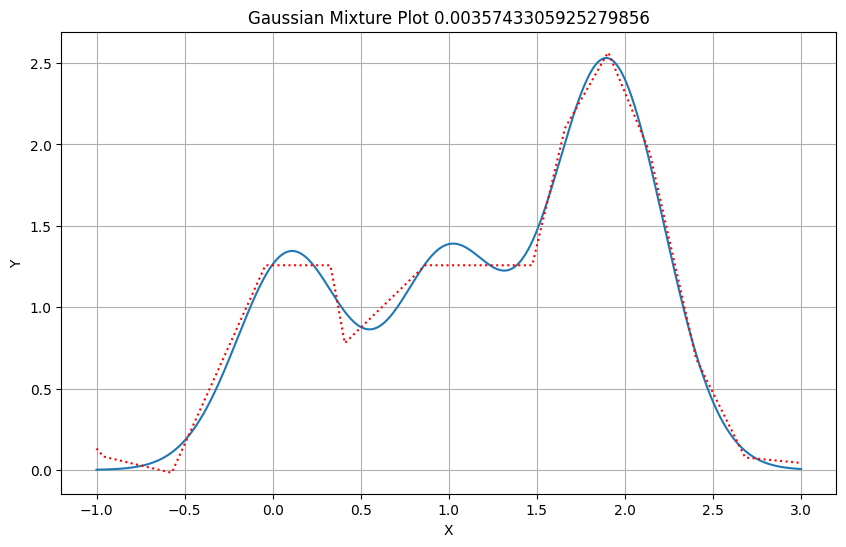

KeyboardInterrupt: 

In [13]:
import torch.profiler
from IPython.display import clear_output

# 890 models or random candidates
# update individual parameters pi, 1 <= i <= 89 using unravel index but on each of the layers....
# 

epochs = 2000

X = torch.rand(4000, 1).to(device) * 5 - 1
Y = gaussian_mixture(X).to(device)

num_params = int(89 / 2) #sum(p.numel() for p in model.parameters() if p.requires_grad)
NP = num_params
CR = 0.9
F = 0.8

model = DE_NN(NP, CR, F, 0.001).to(device)
L = nn.MSELoss().to(device)

#with torch.autograd.profiler.profile(use_device='cuda') as prof:
for e in range(epochs):
    #for model in models:
    for i in range(model.NP):
        model.step(i, X, Y, L, 'block').item()
    #print("min", min(f_lst), "max", max(f_lst), "avg", mean(f_lst))
    
    if e % 5 == 0:
        test_X = torch.linspace(-1, 3, 1000)
        test_Y = gaussian_mixture(test_X)
        model_Y = model(test_X.reshape(-1, 1).to(device)).cpu()
        # Clear the previous output before plotting
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
        plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
        plt.title(f'Gaussian Mixture Plot {model.min_l}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()
        
            #print(f"Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}")
            #print(torch.cuda.utilization())
            #free, total = torch.cuda.mem_get_info(device)
            #mem_used_MB = (total - free) / 1024 ** 2
            #print(mem_used_MB)
            #print(torch.cuda.memory_summary())
    #nvidia-smi -lms 100 --query-gpu=index,gpu_name,memory.total,memory.used,memory.free,temperature.gpu,pstate,utilization.gpu,utilization.memory --format=csv

#print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#prof.export_chrome_trace("trace_with_grad_GPU.json")

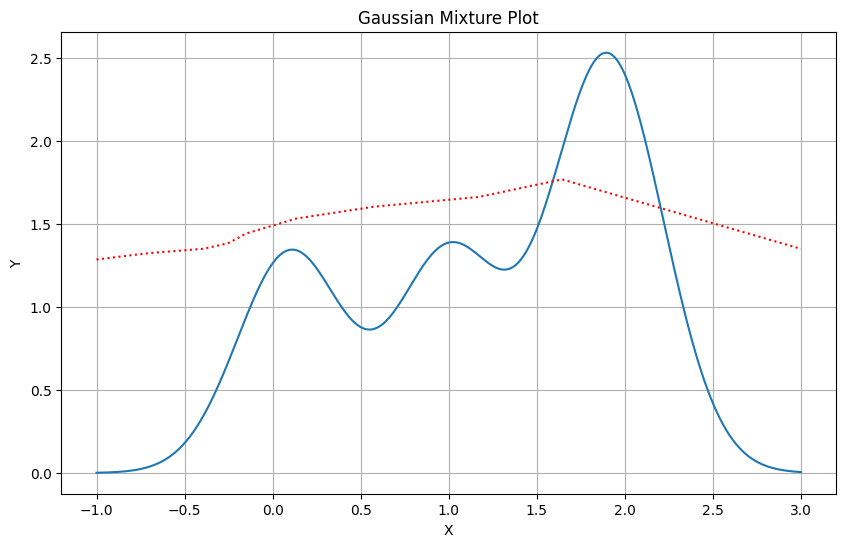

In [5]:
test_X = torch.linspace(-1, 3, 1000)
test_Y = gaussian_mixture(test_X)
model_Y = model(test_X.reshape(-1, 1).to(device))
model_Y = model_Y.cpu()
plt.figure(figsize=(10, 6))
plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
plt.title('Gaussian Mixture Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()